In [ ]:
from google.colab import drive
 
# Accessing My Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# Preprequisites

In [ ]:
! pip uninstall opencv-python-headless==4.5.5.62

In [ ]:
pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 66.9 MB/s 


In [ ]:
import tensorflow as tf
import os
import numpy as np
import cv2
import json
from tqdm import tqdm
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

# Helper functions

In [ ]:
def create_dir(path):
    # Create a directory.
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

def read_data(x, y):
    # Read the image and mask from the given path.
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    return image, mask

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def read_image(x):
    x = x.decode()
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    return image

def read_mask(y):
    y = y.decode()
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask/255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

# Data

## Lesion boundry segmentation

In [ ]:
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip

--2022-01-31 18:03:57--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.146.227
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.216.146.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11165358566 (10G) [application/zip]
Saving to: ‘ISIC2018_Task1-2_Training_Input.zip’

ISIC2018_Task1-2_Tr 100%[===================>]  10.40G  45.2MB/s    in 3m 43s  

2022-01-31 18:07:40 (47.8 MB/s) - ‘ISIC2018_Task1-2_Training_Input.zip’ saved [11165358566/11165358566]



In [ ]:
! mkdir data

In [ ]:
! mkdir data/lesion

In [ ]:
! rm -r ISIC2018_Task1-2_Training_Input

In [ ]:
!unzip ISIC2018_Task1-2_Training_Input.zip

Archive:  ISIC2018_Task1-2_Training_Input.zip
   creating: ISIC2018_Task1-2_Training_Input/
  inflating: ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000000.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000001.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000003.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000004.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000006.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000007.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000008.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000009.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000011.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000012.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000013.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000014.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000015.jpg  
  inflating: 

In [ ]:
! mkdir /content/data/lesion/images

In [ ]:
! mv ISIC2018_Task1-2_Training_Input/*.jpg /content/data/lesion/images

In [ ]:
! wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip

--2022-01-31 18:03:38--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.160.241
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.160.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27402895 (26M) [application/zip]
Saving to: ‘ISIC2018_Task1_Training_GroundTruth.zip’

ISIC2018_Task1_Trai 100%[===================>]  26.13M  37.4MB/s    in 0.7s    

2022-01-31 18:03:38 (37.4 MB/s) - ‘ISIC2018_Task1_Training_GroundTruth.zip’ saved [27402895/27402895]



In [ ]:
!unzip ISIC2018_Task1_Training_GroundTruth.zip

Archive:  ISIC2018_Task1_Training_GroundTruth.zip
   creating: ISIC2018_Task1_Training_GroundTruth/
  inflating: ISIC2018_Task1_Training_GroundTruth/ATTRIBUTION.txt  
  inflating: ISIC2018_Task1_Training_GroundTruth/ISIC_0000000_segmentation.png  
  inflating: ISIC2018_Task1_Training_GroundTruth/ISIC_0000001_segmentation.png  
  inflating: ISIC2018_Task1_Training_GroundTruth/ISIC_0000003_segmentation.png  
  inflating: ISIC2018_Task1_Training_GroundTruth/ISIC_0000004_segmentation.png  
  inflating: ISIC2018_Task1_Training_GroundTruth/ISIC_0000006_segmentation.png  
  inflating: ISIC2018_Task1_Training_GroundTruth/ISIC_0000007_segmentation.png  
  inflating: ISIC2018_Task1_Training_GroundTruth/ISIC_0000008_segmentation.png  
  inflating: ISIC2018_Task1_Training_GroundTruth/ISIC_0000009_segmentation.png  
  inflating: ISIC2018_Task1_Training_GroundTruth/ISIC_0000011_segmentation.png  
  inflating: ISIC2018_Task1_Training_GroundTruth/ISIC_0000012_segmentation.png  
  inflating: ISIC2018_T

In [ ]:
! mkdir /content/data/lesion/masks

In [ ]:
! mv ISIC2018_Task1_Training_GroundTruth/*.png /content/data/lesion/masks

In [ ]:
! rm -r ISIC2018_Task1_Training_GroundTruth

Number of images for lesion boundry segmentation

In [ ]:
! find /content/data/lesion/images -type f | wc -l

2594


Number of masks for lesion boundry segmentation

In [ ]:
! find /content/data/lesion/masks -type f | wc -l

2594


# Pre Processing

## Augmentation

In [ ]:
! pip install -U albumentations

     |████████████████████████████████| 102 kB 10.1 MB/s 
     |████████████████████████████████| 47.7 MB 93 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,
    CenterCrop,
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,
    RandomGamma,
    HueSaturationValue,
    RGBShift,
    RandomBrightness,
    RandomContrast,
    MotionBlur,
    MedianBlur,
    GaussianBlur,
    GaussNoise,
    ChannelShuffle,
    CoarseDropout
)
import albumentations as A

In [ ]:
def augment_data(images, masks, save_path, augment=True):
    """ Performing data augmentation. """
    crop_size = (192-32, 256-32)
    size = (256, 192)

    for image, mask in tqdm(zip(images, masks), total=len(images)):
        image_name = image.split("/")[-1].split(".")[0]
        mask_name = mask.split("/")[-1].split(".")[0]

        x, y = read_data(image, mask)
        try:
            h, w, c = x.shape
        except Exception as e:
            image = image[:-1]
            x, y = read_data(image, mask)
            h, w, c = x.shape

        if augment == True:

            ## Center Crop
            aug = A.CenterCrop(p=1.0, height=crop_size[0], width=crop_size[1])
            augmented = aug(image=x, mask=y)
            x1 = augmented['image']
            y1 = augmented['mask']

            ## Crop
            x_min = 0
            y_min = 0
            x_max = x_min + size[0]
            y_max = y_min + size[1]

            aug = A.Crop(p=1, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            ## Random Rotate 90 degree
            aug = A.RandomRotate90(p=1)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            ## Transpose
            aug = A.Transpose(p=1)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            ## ElasticTransform
            aug = A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            ## Grid Distortion
            aug = A.GridDistortion(p=1)
            augmented = aug(image=x, mask=y)
            x6 = augmented['image']
            y6 = augmented['mask']

            ## Optical Distortion
            aug = A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
            augmented = aug(image=x, mask=y)
            x7 = augmented['image']
            y7 = augmented['mask']

            ## Vertical Flip
            aug = A.VerticalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x8 = augmented['image']
            y8 = augmented['mask']

            ## Horizontal Flip
            aug = A.HorizontalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x9 = augmented['image']
            y9 = augmented['mask']

            ## Grayscale
            x10 = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
            y10 = y

            ## Grayscale Vertical Flip
            aug = A.VerticalFlip(p=1)
            augmented = aug(image=x10, mask=y10)
            x11 = augmented['image']
            y11 = augmented['mask']

            ## Grayscale Horizontal Flip
            aug = A.HorizontalFlip(p=1)
            augmented = aug(image=x10, mask=y10)
            x12 = augmented['image']
            y12 = augmented['mask']

            ## Grayscale Center Crop
            aug = A.CenterCrop(p=1, height=crop_size[0], width=crop_size[1])
            augmented = aug(image=x10, mask=y10)
            x13 = augmented['image']
            y13 = augmented['mask']

            ##
            aug = A.RandomBrightnessContrast(p=1)
            augmented = aug(image=x, mask=y)
            x14 = augmented['image']
            y14 = augmented['mask']

            aug = A.RandomGamma(p=1)
            augmented = aug(image=x, mask=y)
            x15 = augmented['image']
            y15 = augmented['mask']

            aug = A.HueSaturationValue(p=1)
            augmented = aug(image=x, mask=y)
            x16 = augmented['image']
            y16 = augmented['mask']

            aug = A.RGBShift(p=1)
            augmented = aug(image=x, mask=y)
            x17 = augmented['image']
            y17 = augmented['mask']

            aug = A.RandomBrightness(p=1)
            augmented = aug(image=x, mask=y)
            x18 = augmented['image']
            y18 = augmented['mask']

            aug = A.RandomContrast(p=1)
            augmented = aug(image=x, mask=y)
            x19 = augmented['image']
            y19 = augmented['mask']

            aug = A.MotionBlur(p=1, blur_limit=7)
            augmented = aug(image=x, mask=y)
            x20 = augmented['image']
            y20 = augmented['mask']

            aug = A.MedianBlur(p=1, blur_limit=9)
            augmented = aug(image=x, mask=y)
            x21 = augmented['image']
            y21 = augmented['mask']

            aug = A.GaussianBlur(p=1, blur_limit=9)
            augmented = aug(image=x, mask=y)
            x22 = augmented['image']
            y22 = augmented['mask']

            aug = A.GaussNoise(p=1)
            augmented = aug(image=x, mask=y)
            x23 = augmented['image']
            y23 = augmented['mask']

            aug = A.ChannelShuffle(p=1)
            augmented = aug(image=x, mask=y)
            x24 = augmented['image']
            y24 = augmented['mask']

            aug = A.CoarseDropout(p=1, max_holes=8, max_height=32, max_width=32)
            augmented = aug(image=x, mask=y)
            x25 = augmented['image']
            y25 = augmented['mask']

            images = [
                x, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10,
                x11, x12, x13, x14, x15, x16, x17, x18, x19, x20,
                x21, x22, x23, x24, x25
            ]
            masks  = [
                y, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10,
                y11, y12, y13, y14, y15, y16, y17, y18, y19, y20,
                y21, y22, y23, y24, y25
            ]

        else:
            images = [x]
            masks  = [y]

        idx = 0
        for i, m in zip(images, masks):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{image_name}_{idx}.jpg"
            tmp_mask_name  = f"{mask_name}_{idx}.jpg"

            image_path = os.path.join(save_path, "image/", tmp_image_name)
            mask_path  = os.path.join(save_path, "mask/", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1


## Split

In [ ]:
def load_data(path, split=0.1):
    """ Load all the data and then split them into train and valid dataset. """
    img_path = glob(os.path.join(path, "images/*"))
    msk_path = glob(os.path.join(path, "masks/*"))

    img_path.sort()
    msk_path.sort()

    len_ids = len(img_path)
    train_size = int((96/100)*len_ids)
    valid_size = int((2/100)*len_ids)		## Here 10 is the percent of images used for validation
    test_size = int((2/100)*len_ids)		## Here 10 is the percent of images used for testing

    train_x, test_x = train_test_split(img_path, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(msk_path, test_size=test_size, random_state=42)

    train_x, valid_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, valid_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return  (valid_x, valid_y), (test_x, test_y), (train_x, train_y)

In [ ]:
def split_augment_data(path,path2):
    np.random.seed(42)
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path2, split=0.1)

    create_dir(path + "/new_data2/train/image/")
    create_dir(path + "/new_data2/train/mask/")
    create_dir(path + "/new_data2/valid/image/")
    create_dir(path + "/new_data2/valid/mask/")
    create_dir(path + "/new_data2/test/image/")
    create_dir(path + "/new_data2/test/mask/")

    augment_data(train_x, train_y, path + "/new_data2/train/", augment=True)
    augment_data(valid_x, valid_y, path + "/new_data2/valid/", augment=False)
    # augment_data(test_x, test_y, path + "/new_data/test/", augment=False)

## Lesion

In [ ]:
# split_augment_data("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/lesion",,"data/lesion")

  0%|          | 0/2076 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1953: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "
100%|██████████| 259/259 [01:05<00:00,  3.93it/s]


In [ ]:
! find /content/drive/MyDrive/Colab\ Notebooks/vision/double-unet/data/lesion/new_data2/train -type f | wc -l

2652


# PreParing dataset

In [ ]:
def parse_data(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        y = np.concatenate([y, y], axis=-1)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([384, 512, 3])
    y.set_shape([384, 512, 2])
    return x, y
    
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=32)
    dataset = dataset.map(map_func=parse_data)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    return dataset

def prepare_train_data(train_path,valid_path,path):
    np.random.seed(42)
    tf.random.set_seed(42)
    create_dir(path + "/files")

    ## Training
    train_x = sorted(glob(os.path.join(train_path, "image", "*.jpg")))
    train_y = sorted(glob(os.path.join(train_path, "mask", "*.jpg")))

    ## Shuffling
    train_x, train_y = shuffling(train_x, train_y)

    ## Validation
    valid_x = sorted(glob(os.path.join(valid_path, "image", "*.jpg")))
    valid_y = sorted(glob(os.path.join(valid_path, "mask", "*.jpg")))

    return train_x,train_y, valid_x, valid_y

## Lesion

In [ ]:
train_x,train_y, valid_x, valid_y = prepare_train_data("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/lesion/new_data2/train/","/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/lesion/new_data2/valid/","/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/lesion")

In [ ]:
batch_size = 4

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [ ]:
train_dataset

<BatchDataset shapes: ((None, 384, 512, 3), (None, 384, 512, 2)), types: (tf.float32, tf.float32)>

# Model

The double-unet model consists of two semi-unet networks as it is shown in the following diagram.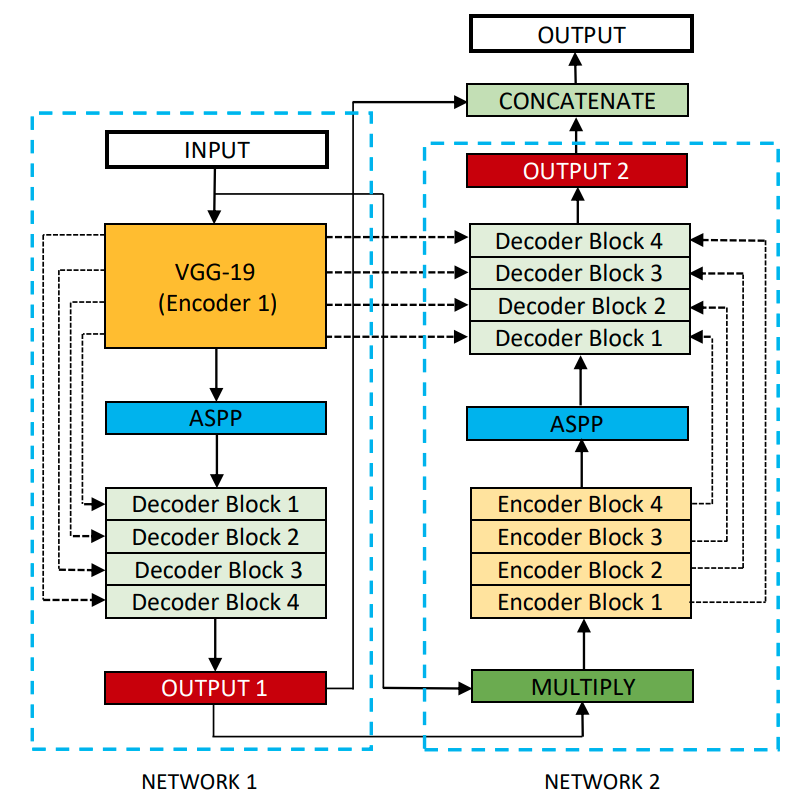

In [ ]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

# ===================================== Network 1 =============================================

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

# ===================================== Network 2 =============================================

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

#=============================== double-unet Model ================================

def doubleunet_model(shape):
  # network 1
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)
    
  # input to the second network
    x = inputs * outputs1

  # network 2
    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs)
    plot_model(model, to_file='segmentation_model.png', show_shapes=True, show_layer_names=True)
    return model


## Metrics

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

# Train

In [ ]:
model_base_path = "/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data"
epochs = 300
lr = 1e-4
shape = (384, 512, 3)

In [ ]:
model = doubleunet_model(shape)
metrics = [
        dice_coef,
        iou,
        Recall(),
        Precision()]

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/lesion/files/"+"model3.h5",custom_objects={'dice_loss': dice_loss, 'dice_coef':dice_coef,'iou':iou})
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)


In [ ]:
def train_model(train_dataset,valid_dataset,train_x,valid_x,batch_size,epochs,path):
  callbacks = [
          ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/lesion/files/"+"model3.h5",),
          ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20),
          CSVLogger("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/lesion/files/"+"data3.csv"),
          TensorBoard(),
          EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
  ]

  train_steps = (len(train_x)//batch_size)
  valid_steps = (len(valid_x)//batch_size)

  if len(train_x) % batch_size != 0:
        train_steps += 1

  if len(valid_x) % batch_size != 0:
        valid_steps += 1

  model.fit(train_dataset,
              epochs=50,
              initial_epoch= 5,
              validation_data=valid_dataset,
              steps_per_epoch=train_steps,
              validation_steps=valid_steps,
              callbacks=callbacks,
              verbose=1,
              shuffle=False)
  return model

## Lesion

In [ ]:
model_lesion = train_model(train_dataset,valid_dataset,train_x[:10000],valid_x,2,epochs,"/lesion/files/")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 6/50
5000/5000 [==============================] - 6204s 1s/step - loss: 0.1755 - dice_coef: 0.8245 - iou: 0.7312 - recall: 0.8095 - precision: 0.8764 - val_loss: 0.1284 - val_dice_coef: 0.8716 - val_iou: 0.7820 - val_recall: 0.8378 - val_precision: 0.9289 - lr: 1.0000e-04
Epoch 7/50
5000/5000 [==============================] - 2618s 523ms/step - loss: 0.1625 - dice_coef: 0.8375 - iou: 0.7485 - recall: 0.8249 - precision: 0.8842 - val_loss: 0.1338 - val_dice_coef: 0.8662 - val_iou: 0.7744 - val_recall: 0.8596 - val_precision: 0.9069 - lr: 1.0000e-04
Epoch 8/50
5000/5000 [==============================] - 2620s 524ms/step - loss: 0.1563 - dice_coef: 0.8437 - iou: 0.7566 - recall: 0.8325 - precision: 0.8866 - val_loss: 0.1368 - val_dice_coef: 0.8632 - val_iou: 0.7713 - val_recall: 0.8197 - val_precision: 0.9305 - lr: 1.0000e-04
Epoch 9/50
2532/5000 [==============>...............] - ETA: 21:18 - loss: 0.1494 - dice_coef: 0.8506 - iou: 0.7656 - recall: 0.8398 - precision: 0.8943

# Prediction

In [ ]:
test_path = "/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/lesion/new_data1/test/test/"

In [ ]:
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/lesion/files/"+"model3.h5",custom_objects={'dice_loss': dice_loss, 'dice_coef':dice_coef,'iou':iou},compile=False)

In [ ]:
def evaluating_model(test_x, test_y):
    np.random.seed(42)
    tf.random.set_seed(42)

    batch_size = 1

    print(len(test_x))
    test_dataset = tf_dataset(test_x, test_y)

    test_steps = (len(test_x)//batch_size)
    if len(test_x) % batch_size != 0:
        test_steps += 1

    # model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/lesion/files/"+"model3.h5",custom_objects={'dice_loss': dice_loss, 'dice_coef':dice_coef,'iou':iou}, compile=False)
    print("evaluate")
    model.evaluate(test_dataset, steps=test_steps)


In [ ]:
evaluating_model(test_x, test_y)

259
evaluate
130/130 [==============================] - 1621s 12s/step - loss: 0.1604 - dice_coef: 0.8396 - iou: 0.7404 - recall: 0.8092 - precision: 0.9211


In [ ]:
evaluating_model()

259
evaluate
259/259 [==============================] - 583s 2s/step - loss: 0.1529 - dice_coef: 0.8471 - iou: 0.7421 - recall_1: 0.8080 - precision_1: 0.9203


# Visualisation

In [ ]:
#@title Load model and test set
test_path = "/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/lesion/new_data1/test/test/"
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/lesion/files/"+"model3.h5",custom_objects={'dice_loss': dice_loss, 'dice_coef':dice_coef,'iou':iou},compile=False)


path is :  /content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/lesion/new_data1/test/test/image/ISIC_0016071_0.jpg


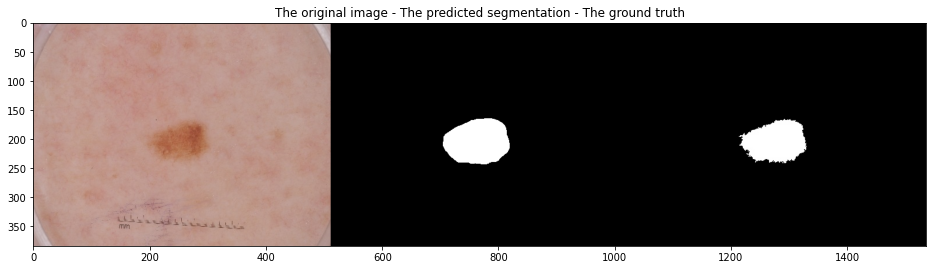

In [ ]:
#@title Segment an image
import sklearn
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

size = (512, 384)

def preprocessing(img):
    size = (512, 384)
    img2 = cv2.resize(img, size)
    img2 = np.clip(img2 - np.median(img2)+127, 0, 255)
    img2 = img2.astype(np.float32)

    img2 = img2/255.
    return img2


def get_predict(model, img):
    processed_img = preprocessing(img)
    processed_img = np.expand_dims(processed_img, axis=0)
    out_put = model.predict(processed_img)
    out_put = out_put[..., -1]
    out_put = out_put[0]
    out_put = sklearn.preprocessing.binarize(out_put, threshold=0.5)
    out_put = out_put*255.
    return out_put

#@markdown Choose a number between 1 to 259
index =  5#@param {type:"integer"}

x = test_x[index-1]
y = test_y[index-1]
print("path is : ", x)
img2 = cv2.imread(x, cv2.IMREAD_COLOR)
groundthruth = cv2.imread(y, cv2.IMREAD_COLOR)
out_put = get_predict(model, img2)
out_put = out_put.astype(np.uint8)
out_put = np.stack([out_put, out_put, out_put], axis=-1)
out_put2 = np.concatenate([cv2.resize(img2, size), out_put, groundthruth], axis=1)
# cv2_imshow(out_put2)
plt.figure(figsize=(16, 8))
plt.title("The original image - The predicted segmentation - The ground truth")
plt.imshow(cv2.cvtColor(out_put2, cv2.COLOR_BGR2RGB))